## INF367 Mandatory Assignment 2

<p style="text-align:right;"><b>Written by:</b> Tobias Husebø, Lasse Holt, Martin Flo Øfstaas</p>
    <p style="text-align:right;"><i>Due: 8th of November 2024, (12:00)</i></p>

NB! look in notebook for more in-detail report

---

### Imports

We start of by declaring all imports used in the assignment.


In [6]:
# SKLEARN:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# QISKIT:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector

# PANDAS:
import pandas as pd

# NUMPY:
import numpy as np

# MATPLOTLIB:
import matplotlib.pyplot as plt

# COPY
import copy as c

---

&nbsp;

### Data initialization:

We start of by initializing our dataset. We do this via sklearns `load_iris()`. Furthermore we wish to explore the entirety of the dataset and not only the training subset. There is a few reasons for this. Firstly, the dataset is already relatively small. This means that splitting it via `train_test_split()` may not provide a represenative view of its characteristics. Thus, data exploration on the training subset may yield skewed pictures of what the data actually looks like. Secondly, the iris dataset is well-known and most of us has already worked with it, meaning concerns about data leakage are minimal.

In [7]:
# Loading the dataset:
data = load_iris()
X = data.data
y = data.target

---

&nbsp;

### Data Exploration:

In our data exploration step, we start of by looking at some fundamental properties of the dataset. Namely, missing values, label distribution and more. This leads to valuable insight which in return may help us choose a preformance metric, which encoding to utilize and etc.

We start of by defining some functions for the data exploration:

In [3]:
features = data.feature_names
labels = data.target_names
num_datapoints = len(X)
num_dims = len(features)


# Print the counts of datapoints, dims and alike
def dataset_counts(X, y):
    out_string = f"\nThe dataset contains {num_datapoints} datapoints"
    out_string += f"\nThe dataset contains {len(features)} dimensions\n\n"

    for i in range(len(features)):
        out_string += f"Feature {i+1}: {features[i]}\n"
        out_string += (
            f"Feature {i+1} value interval [{np.min(X[:,i])}, {np.max(X[:,i])}]\n\n"
        )

    print(out_string)


# Print out missing values (if any)
def missing_values_dataset(X, y):
    missing_X = np.isnan(X).any()
    missing_y = np.isnan(y).any()

    if missing_X or missing_y:
        print("The dataset contains one or more missing values.")
    else:
        print("The dataset is complete.")


# Visualize label distribution
def feature_count_distribution(X):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()  # Flatten the axes array for easy indexing

    # Plot each feature in a separate subplot
    for i in range(len(features)):
        axes[i].hist(X[:, i], bins=20, color="blue", alpha=0.7)
        axes[i].set_title(f"{features[i]} distribution")
        axes[i].set_xlabel("Value")
        axes[i].grid(axis="y")
        axes[i].set_ylabel("Frequency")

    fig.suptitle(
        "Fig 1 - Distribution of Each Feature in Iris Dataset",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()


# Visualize label distribution
def label_distribution(y):
    _, counts = np.unique(y, return_counts=True)
    ticks = [label for label in labels]
    colors = plt.cm.tab10.colors[: len(counts)]

    plt.bar(np.arange(len(counts)), counts, tick_label=ticks, color=colors)
    plt.xlabel("Each distinct label")
    plt.ylabel("Label count")
    plt.grid(axis="y")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.title("Fig 2 - Distribution of Labels", fontsize=14, fontweight="bold")
    plt.show()

&nbsp;

After defining some functions we can utilize them to gain valuable insight:

In [4]:
dataset_counts(X, y)


The dataset contains 150 datapoints
The dataset contains 4 dimensions

Feature 1: sepal length (cm)
Feature 1 value interval [4.3, 7.9]

Feature 2: sepal width (cm)
Feature 2 value interval [2.0, 4.4]

Feature 3: petal length (cm)
Feature 3 value interval [1.0, 6.9]

Feature 4: petal width (cm)
Feature 4 value interval [0.1, 2.5]




In [5]:
missing_values_dataset(X, y)

The dataset is complete.


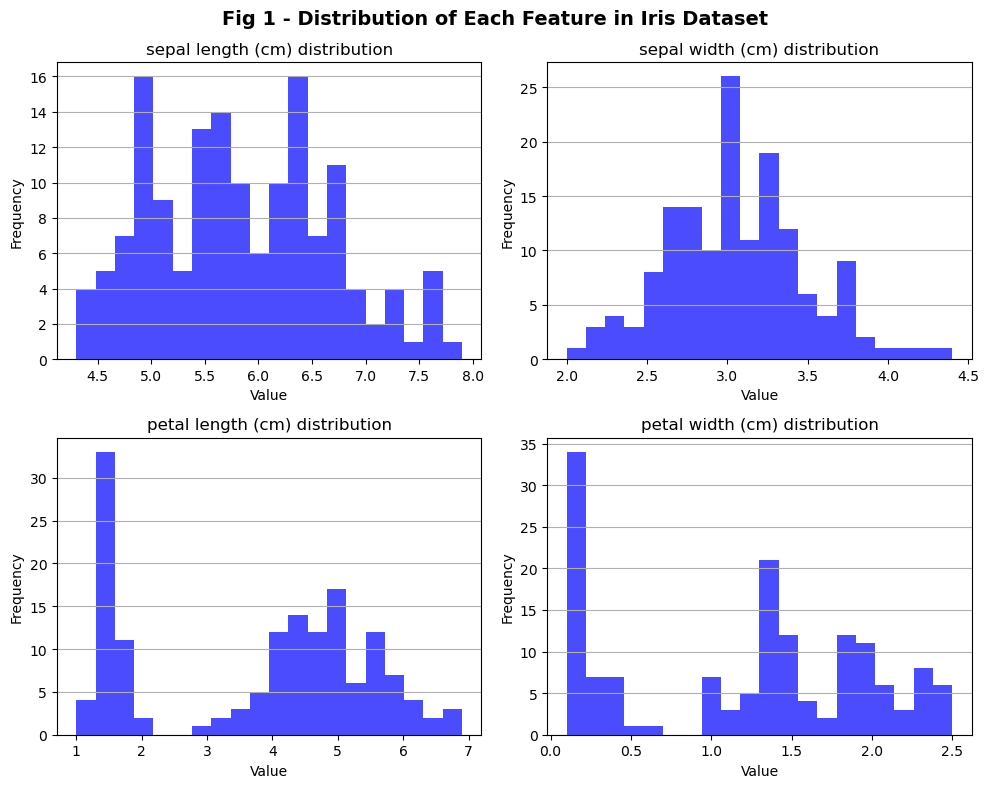

In [6]:
feature_count_distribution(X)

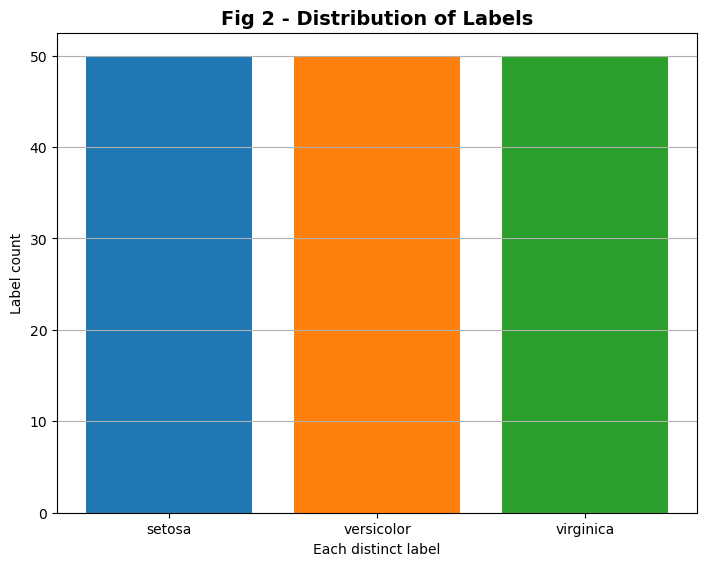

In [7]:
label_distribution(y)

&nbsp;

After running our exploration functions we have gained some insight which will help us further on in the preprocessing / encoding step.

---

&nbsp;

### Data Preprocessing / Encoding:

#### PCA - Principal Component Analysis:

In our preprocessing stage we start of by visualizing the cumulative explained variance of each principal component, via the function `PCA_on_dataset(X):`

In [8]:
def PCA_on_dataset(X):
    # Initializing PCA object with seed for reproducibility:
    seed = 55
    pca = PCA(random_state=seed)
    pca.fit(X)

    # Visualize the cumulative variance:
    svs = pca.singular_values_
    expl_variance = pca.explained_variance_ratio_

    plt.plot(
        np.arange(1, len(svs) + 1, 1),
        [sum(expl_variance[: i + 1]) * 100 for i in range(len(expl_variance))],
    )
    plt.yticks(np.arange(80, 101, 1))
    plt.xticks(np.arange(1, len(svs) + 0.1, 1))
    plt.ylim(78, 102)
    plt.xlabel("Number of PCs")
    plt.ylabel("Cumulative explained variance (%)")
    plt.title("Fig 3 - PCA on Dataset", fontsize=14, fontweight="bold")
    plt.grid()

    plt.show()

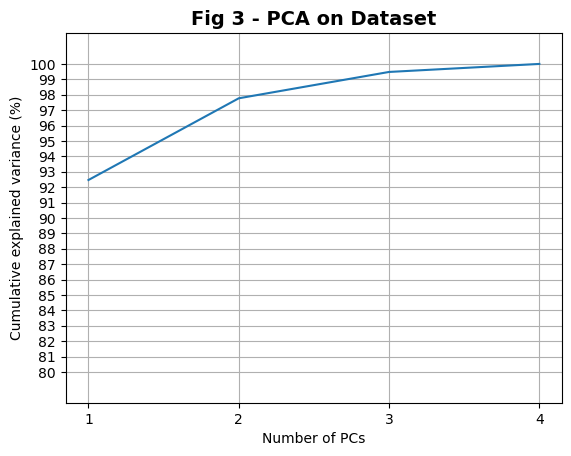

In [9]:
PCA_on_dataset(X)

Via looking at this it is clear that by utilizing only 2 of our 4 principal components we are able to capture `98%` of the information in the original dataset. Thus, we can simply project our datapoints on the axes´ formed by the first and second principal component to reduce the dimensionality and maintain almost all information in the dataset.

Thus, we reduce the dimensionality from 4 to 2 via `dim_reduction(X, num_PCs)`. Additionally, we can plot the data with `scatter_plot_2d_data(X, y)` to visualize that the first 2 PC´s capture most of the information:

In [10]:
def dim_reduction(X, num_PCs):
    # Initializing PCA object with seed for reproducibility:
    seed = 55
    pca = PCA(random_state=seed, n_components=2)
    return pca.fit_transform(X)


X = dim_reduction(X, 2)

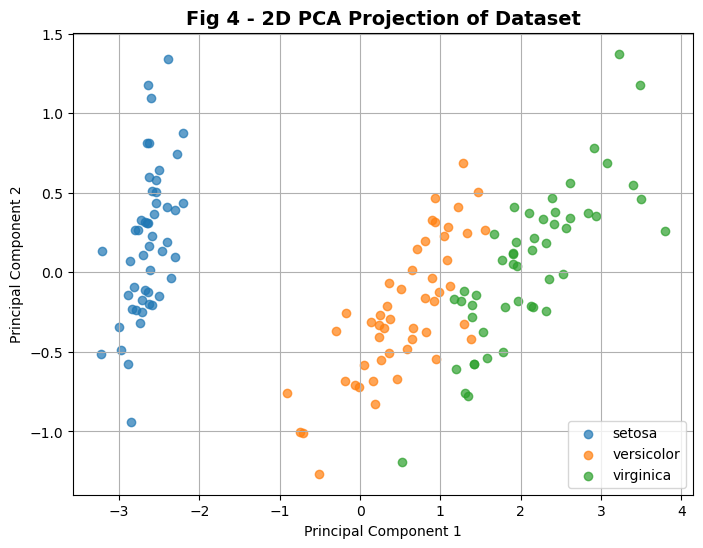

In [11]:
# Assuming `X` is the transformed data with 2 components and `y` contains the labels
def scatter_plot_2d_data(X, y, xlabel, ylabel, title, radian_ticks):
    # Define colors for each class
    colors = plt.cm.tab10.colors[: len(labels)]
    labels_nr = [0, 1, 2]

    plt.figure(figsize=(8, 6))

    # Plot each class with a different color
    for i, label in enumerate(labels_nr):
        plt.scatter(
            X[y == label, 0],
            X[y == label, 1],
            color=colors[i],
            label=f"{labels[i]}",
            alpha=0.7,
        )

    if radian_ticks == True:
        ticks = np.linspace(0, 2 * np.pi, 5)  # Adjust the number of ticks as needed
        tick_labels = [
            f"{i:.2f}π" for i in np.linspace(0, 2, 5)
        ]  # Labels like "0π", "0.5π", "1.0π", etc.

        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.show()


scatter_plot_2d_data(
    X,
    y,
    "Principal Component 1",
    "Principal Component 2",
    "Fig 4 - 2D PCA Projection of Dataset",
    False,
)

&nbsp;

Now we have reduced the dimensionality of our datavector X, and furthermore plotted it. We can see from our plot that via applying PCA we have still retained most of the information in the original dataset as there appears clear clusters for each class.

---

&nbsp;

#### Scaling / Encoding:

In our implementation of the QNN we have concluded that angle encoding is the way to go for the dataset at hand. For further information on our choice look at the report. This means that we have to scale it on a scale from $ x \in [0, 2\pi]$ as information, because $\forall a, a + 2\pi = a$, meaning we can not distinguish between these values with angle encoding. Thus, we scale via sklearns `MinMaxScaler()` function. We also want to plot the data to see that we still have maintained the original "structure" of the dataset: 

In [9]:
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi - 0.01))
X = scaler.fit_transform(X)

# scatter_plot_2d_data(
#     X,
#     y,
#     "Principal Component 1",
#     "Principal Component 2",
#     "Fig 5 - 2D Scaled PCA Projection of Dataset",
#     True,
# )

---

&nbsp;

#### Splitting the data:

After scaling the data, we can at last split it via sklearns `train_test_split()` function:

In [10]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=0.30, random_state=55, stratify=y
)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.50, random_state=55, stratify=y_val_test
)

---

&nbsp;

### Model selection / Circuit creation

#### Circuit Creation

##### Circuit 1:

In the following code block we will define our first `IrisQNN_RealAmp` class which is a Quantum Neural Network "circuit" which is based on the circuit defined as Real Amplitudes by IBM.  

In [11]:
class IrisQNN_RealAmp:
    """
    Class representing an implementation of the
    Real Amplitudes QNN.

    Attributes:
        - n_qubits (Int): Number of qubits in the QNN.
        - n_layers (Int): Number of layers to the variational part.
        - n_params (Int): Number of parameters to the variational layer(s).
        - params (ParameterVector): List of the actual parameters for the variational layer(s).
        - qc (QuantumCircuit): The actual QNN / Quantum circuit

    Functions:
        - create_circuit(): Creates the QNN
        - _angle_encoding(): Priv. func to angle encode datapoint.
        - _add_variational_layer_real_amplitude(): Priv. func to add variational layer.
    """

    def __init__(self, n_qubits, n_layers):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_params = n_qubits * n_layers
        self.param_values = None
        self.params = None
        self.qc = None

    def create_circuit(self, input_features):
        """
        A function for creating a Real Amp. circuit
        with the set parameters

        Parameters:
        - input_features (List[Float]): List of input_features to encode

        Calls:
        - _angle_encoding()
        - _add_variational_layer_real_amplitude()
        """
        # Initialize Quantum Circuit with new params and apply angle encoding:
        qc = QuantumCircuit(self.n_qubits)
        self.params = ParameterVector("θ", self.n_params)
        self._angle_encoding(qc, input_features)

        # For each layer, add a variational layer:
        for layer in range(self.n_layers):
            self._add_variational_layer_real_amplitude(qc, layer)

        # Add measurement in the end
        qc.measure_all()

        self.qc = qc

    def _angle_encoding(self, qc, input_features):
        """
        A function to angle encode the qubits at init.
        of the Real Amp. circuit

        Parameters:
        - qc (QuantumCircuit): Circuit to apply encoding layer to
        - input_features(List[Float]): List of features to encode
        """
        # For each qubit, add Rx-Gate for encoding
        for qubit in range(qc.num_qubits):
            qc.rx(input_features[qubit], qubit)
        qc.barrier()

    def _add_variational_layer_real_amplitude(self, qc, layer_idx):
        """
        A function for applying a variational layer to
        the Real Amp. Circuit

        Parameters:
        - qc (QuantumCircuit): Circuit to apply var. layer to
        - layer_idx(Int): The index of the current layer
        """
        # Param offset to shift to next layer
        param_offset = layer_idx * self.n_qubits

        # Add Ry-Gate to each qubit with set of params
        for i in range(self.n_qubits):
            qc.ry(self.params[param_offset + i], i)

        # Add CX-Gate for entanglement
        for i in range(self.n_qubits - 1):
            qc.cx(i, i + 1)

        # Add barrier after each "variational" part:
        if layer_idx < self.n_layers - 1:
            qc.barrier()

    def get_parameter_count(self):
        """Getter function for returning the parameter count"""
        return self.n_params


In [12]:
# Quick seethrough to see that we have managed to:
IrisQNN = IrisQNN_RealAmp(4, 5)
IrisQNN.create_circuit(X_train[0])  # Create the circuit with input features
IrisQNN.param_values = np.random.uniform(0, 2 * np.pi, IrisQNN.n_params)
IrisQNN.qc.assign_parameters(
    {IrisQNN.params[i]: IrisQNN.param_values[i] for i in range(IrisQNN.n_params)},
    inplace=True,
)

print(IrisQNN.param_values)
print(IrisQNN.qc)

[1.00099988 5.35890059 0.54727314 5.37033398 4.62034782 5.49506111
 5.70956184 6.14060793 0.51473202 1.64014679 2.2901928  2.59353094
 5.93071387 3.42025795 2.4994794  2.13526378 3.98122765 2.59895724
 4.36226334 6.0199952 ]
        ┌───────────┐  ░  ┌───────────┐                 ░ ┌────────────┐     »
   q_0: ┤ Rx(1.394) ├──░──┤ Ry(1.001) ├───■─────────────░─┤ Ry(4.6203) ├──■──»
        ├───────────┴┐ ░  ├───────────┴┐┌─┴─┐           ░ ├────────────┤┌─┴─┐»
   q_1: ┤ Rx(1.3069) ├─░──┤ Ry(5.3589) ├┤ X ├──■────────░─┤ Ry(5.4951) ├┤ X ├»
        ├────────────┤ ░ ┌┴────────────┤└───┘┌─┴─┐      ░ ├────────────┤└───┘»
   q_2: ┤ Rx(2.1265) ├─░─┤ Ry(0.54727) ├─────┤ X ├──■───░─┤ Ry(5.7096) ├─────»
        ├────────────┤ ░ └┬────────────┤     └───┘┌─┴─┐ ░ ├────────────┤     »
   q_3: ┤ Rx(2.6138) ├─░──┤ Ry(5.3703) ├──────────┤ X ├─░─┤ Ry(6.1406) ├─────»
        └────────────┘ ░  └────────────┘          └───┘ ░ └────────────┘     »
meas: 4/════════════════════════════════════════════════════════

#### Training our Circuits:

In the following stage we will train our circuits. This training is conducted with regards to a specificed loss functions given to our "training" class. Below we will define our training class `train_QNN` which is utilized to train models in epochs and batches.

Firstly, we define our loss functions:

In [13]:
class Loss_functions:
    """
    Class defining loss functions for usage in our training class

    Functions:
    - compute_loss_CE(): Loss function for computing Categorical Cross Entropy.
    """

    def compute_loss_CE(self, predicted, actual):
        """Compute Categorical Cross Entropy Loss"""
        # Epsilon to ensure we never encounter log(0)
        eps = 1e-10
        return -np.sum(
            [i * np.log(j if j != 0 else j + eps) for i, j in zip(actual, predicted)]
        )

In [23]:
class Train_QNN:
    def __init__(self, X, y, QNN, loss_func, n_epochs, batch_size, learning_rate, patience):
        self.X = X
        self.y = y
        self.QNN = QNN
        self.loss_func = loss_func
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.backend = QasmSimulator()
        self.batch_size = batch_size
        self.best_params = None
        self.patience = patience

        # Initialize parameters if not already initialized
        if self.QNN.param_values is None:
            self.QNN.param_values = np.random.uniform(0, 2 * np.pi, self.QNN.n_params)


    def train(self, shots, epsilon, patience):
        train_losses = []
        best_loss = np.inf
        patience_counter = 0
        n_samples = len(self.X)

        for epoch in range(self.n_epochs):
            print(f"------ EPOCH {epoch+1} ------")
            epoch_loss = 0.0

            indices = np.random.permutation(n_samples)

            for batch_start_idx in range(0, n_samples, self.batch_size):
                batch_indices = indices[
                    batch_start_idx : batch_start_idx + self.batch_size
                ]
                batch_loss = self._train_batch(batch_indices, shots, epsilon)
                epoch_loss += batch_loss

            avg_epoch_loss = epoch_loss / n_samples
            train_losses.append(avg_epoch_loss)

            if avg_epoch_loss < best_loss:
                best_loss = avg_epoch_loss
                self.best_params = np.copy(self.QNN.param_values)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            print(f"Epoch {epoch+1} - Loss: {avg_epoch_loss}")
        return train_losses
    
    def _create_and_bind_circuit(self, x, params):
        self.QNN.create_circuit(x)
        if params is not None:
            self.QNN.qc.assign_parameters(
                {self.QNN.params[i]: params[i] for i in range(len(params))},
                inplace=True,
            )
        return self.QNN.qc

    def _train_batch(self, batch_indices, shots, epsilon):
        batch_gradients = np.zeros(self.QNN.n_params)
        batch_loss = 0.0

        for idx in batch_indices:
            qc = self._create_and_bind_circuit(self.X[idx], self.QNN.param_values)

            # execute circiut and compute loss
            actual, decoded_result = self._bin_decode(
                self._exec_circuit(qc, shots), idx
            )
            loss = self.loss_func.compute_loss_CE(decoded_result, actual)
            batch_loss += loss

            # compute gradients
            gradients = self._finiteDifference(epsilon, idx, shots)
            batch_gradients += gradients

        # avg gradients over batch
        batch_gradients /= len(batch_indices)
        self._update_param_vals(self.learning_rate, batch_gradients)

        return batch_loss

    def _finiteDifference(self, epsilon, batch, shots):
        gradients = np.zeros(self.QNN.n_params)
        param_values = np.copy(self.QNN.param_values)

        for i in range(self.QNN.n_params):
            forward_params = np.copy(param_values)
            forward_params[i] += epsilon
            backward_params = np.copy(param_values)
            backward_params[i] -= epsilon
            # forward

            qc_forward = self._create_and_bind_circuit(self.X[batch], forward_params)
            actual, decoded_result = self._bin_decode(
                self._exec_circuit(qc_forward, shots), batch
            )
            loss_forward = self.loss_func.compute_loss_CE(decoded_result, actual)

            # backwards
            qc_backward = self._create_and_bind_circuit(self.X[batch], backward_params)
            actual, decoded_result = self._bin_decode(
                self._exec_circuit(qc_backward, shots), batch
            )
            loss_backward = self.loss_func.compute_loss_CE(decoded_result, actual)

            gradients[i] = (loss_forward - loss_backward) / (2 * epsilon)

        return gradients

    def _update_param_vals(self, alpha, gradients):
        self.QNN.param_values = self.QNN.param_values - (alpha * np.array(gradients))

    def _exec_circuit(self, qc, shots=1000):
        transpiled_qc = transpile(qc, self.backend)
        job = self.backend.run(transpiled_qc, shots=shots)
        return job.result()

    def _bin_decode(self, result, y_idx, shots=1000):
        counts = result.get_counts()
        probabilities = np.zeros(3)

        for bitstring, count in counts.items():
            classIndex = int(bitstring, 2) % 3
            probabilities[classIndex] += count / shots

        probabilities /= np.sum(probabilities)
        actual = np.zeros(3)
        actual[self.y[y_idx]] = 1

        return actual, probabilities

In [24]:
# TESTING TRAINING:
loss_func_cl = Loss_functions()

myQNN = IrisQNN_RealAmp(4, 5)

# Create trainer
trainer = Train_QNN(X_train, y_train, myQNN, loss_func_cl, 20, 10, 0.1, 5)

# Train the model
losses = trainer.train(shots = 200, epsilon = 0.01, patience = 5)

------ EPOCH 1 ------
Epoch 1 - Loss: 1.2333998231385177
------ EPOCH 2 ------
Epoch 2 - Loss: 1.0113740406802796
------ EPOCH 3 ------
Epoch 3 - Loss: 1.0946775996826952
------ EPOCH 4 ------
Epoch 4 - Loss: 1.2374325860384006
------ EPOCH 5 ------
Epoch 5 - Loss: 1.0712739765356418
------ EPOCH 6 ------
Epoch 6 - Loss: 0.9177151371445113
------ EPOCH 7 ------
Epoch 7 - Loss: 1.2518184670344104
------ EPOCH 8 ------
Epoch 8 - Loss: 1.0713424076832887
------ EPOCH 9 ------
Epoch 9 - Loss: 0.9716665093935182
------ EPOCH 10 ------
Epoch 10 - Loss: 1.048260446260383
------ EPOCH 11 ------
Early stopping at epoch 11


In [17]:
import seaborn as sns


def evaluate_qnn(trainer, X_val, y_val, shots=1000):

    predictions = []
    val_loss = 0.0
    correct_predictions = 0
    confusion_mat = np.zeros((3, 3), dtype=int)

    eval_params = (
        trainer.best_params
        if trainer.best_params is not None
        else trainer.QNN.param_values
    )

    for idx in range(len(X_val)):
        try:

            trainer.QNN.create_circuit(X_val[idx])


            trainer.QNN.qc.assign_parameters(
                {
                    trainer.QNN.params[i]: eval_params[i]
                    for i in range(len(eval_params))
                },
                inplace=True,
            )


            transpiled_qc = transpile(trainer.QNN.qc, trainer.backend)
            job = trainer.backend.run(transpiled_qc, shots=shots)
            result = job.result()


            actual = np.zeros(3)
            actual[y_val[idx]] = 1
            counts = result.get_counts()


            probabilities = np.zeros(3)
            for bitstring, count in counts.items():
                classIndex = int(bitstring, 2) % 3
                probabilities[classIndex] += count / shots
            probabilities /= np.sum(probabilities)

            predictions.append(probabilities)


            val_loss += trainer.loss_func.compute_loss_CE(probabilities, actual)


            predicted_class = np.argmax(probabilities)
            true_class = y_val[idx]


            confusion_mat[true_class][predicted_class] += 1


            if predicted_class == true_class:
                correct_predictions += 1

        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")
            continue

    accuracy = correct_predictions / len(X_val)
    avg_loss = val_loss / len(X_val)

    return {
        "accuracy": accuracy,
        "loss": avg_loss,
        "predictions": predictions,
        "confusion_matrix": confusion_mat,
    }


def plot_evaluation_results(eval_results, train_losses=None):

    plt.figure(figsize=(12, 5))

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(
        eval_results["confusion_matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Class 0", "Class 1", "Class 2"],
        yticklabels=["Class 0", "Class 1", "Class 2"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Plot training losses if provided
    if train_losses is not None:
        plt.subplot(1, 2, 2)
        plt.plot(train_losses)
        plt.title("Training Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()

In [ ]:
eval_results = evaluate_qnn(trainer, X_validation, y_validation)


print("\nValidation Results:")
print(f"Accuracy: {eval_results['accuracy']:.4f}")
print(f"Average Loss: {eval_results['loss']:.4f}")


plot_evaluation_results(eval_results)

In [ ]:
import pickle


save_params = trainer.best_params

with open("best_params.pkl", "wb") as f:
    pickle.dump(save_params, f)

with open("best_params.pkl", "rb") as f:
    loaded_params = pickle.load(f)

print(np.allclose(save_params, loaded_params))

NameError: name 'trainer' is not defined


Test Results:
Accuracy: 0.6522
Average Loss: 1.0063


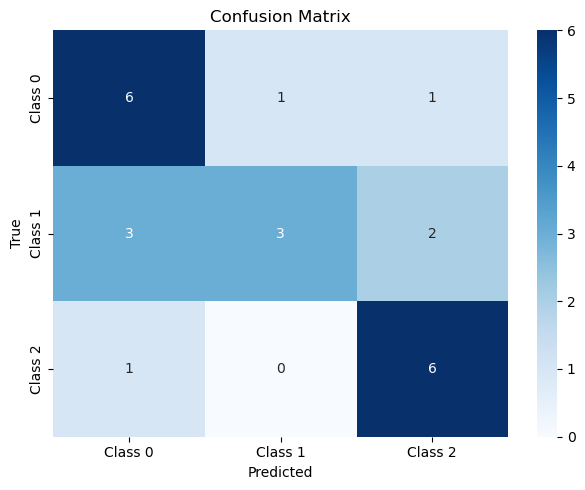

In [19]:
loss_func_cl = Loss_functions()

def load_best_params_and_test(QNN, X_test, y_test, params_file="best_params.pkl", shots=1000):
    # Load the best parameters from the file
    with open(params_file, "rb") as f:
        best_params = pickle.load(f)
    
    # Create a minimal trainer object just for evaluation
    minimal_trainer = type('MinimalTrainer', (), {
        'QNN': QNN,
        'backend': QasmSimulator(),
        'loss_func': Loss_functions(),
        'best_params': best_params
    })()
    
    # Evaluate using the minimal trainer
    eval_results = evaluate_qnn(minimal_trainer, X_test, y_test, shots)
    
    # Print the evaluation results
    print("\nTest Results:")
    print(f"Accuracy: {eval_results['accuracy']:.4f}")
    print(f"Average Loss: {eval_results['loss']:.4f}")
    
    # Plot the evaluation results
    plot_evaluation_results(eval_results)

# Example usage:
testing_QNN = IrisQNN_RealAmp(4, 5)
load_best_params_and_test(testing_QNN, X_test, y_test)